# Image Compression with Singular Value Decomposition (SVD)
[Singular Value Decomposition (SVD)](https://medium.com/@sudhanshumukherjeexx/how-to-use-singular-value-decomposition-for-image-compression-7d45882f9f23) and Principal Component Analysis (PCA) are two closely related linear algebra techniques commonly used for dimensionality reduction—and both can be applied to image compression.

## Algorithms for Image Compression
1. **SVD for Image Compression:** SVD decomposes an image represented as a matrix into three matrices

<center><img src="matrix_visual.jpeg" width="400"/></center>

- **U**: contains the left singular vectors, representing patterns across rows (image height).
- **S**: is a diagonal matrix of singular values, which indicate the strength or importance of each pattern.
- **Vᵗ**: contains the right singular vectors, representing patterns across columns (image width).

    To compress an image, we keep only the top k singular values and corresponding vectors, reconstructing the image with fewer components while retaining most visual details. This results in a low-rank approximation of the original matrix.

2. **PCA for Image Compression**

    [PCA](../3.%20Principal%20Component%20Analysis/pca.ipynb) also finds a lower-dimensional representation of data, but it's derived through eigendecomposition of the covariance matrix of the image or SVD on mean-centered data. In PCA:
- The principal components are the eigenvectors of the covariance matrix.

- These components form new axes along which the data varies the most.

- To compress an image, PCA projects the image data onto the top k principal components and reconstructs the image using only those components.

## Implement and Evaluate Model
(on an image of my adorable dog)

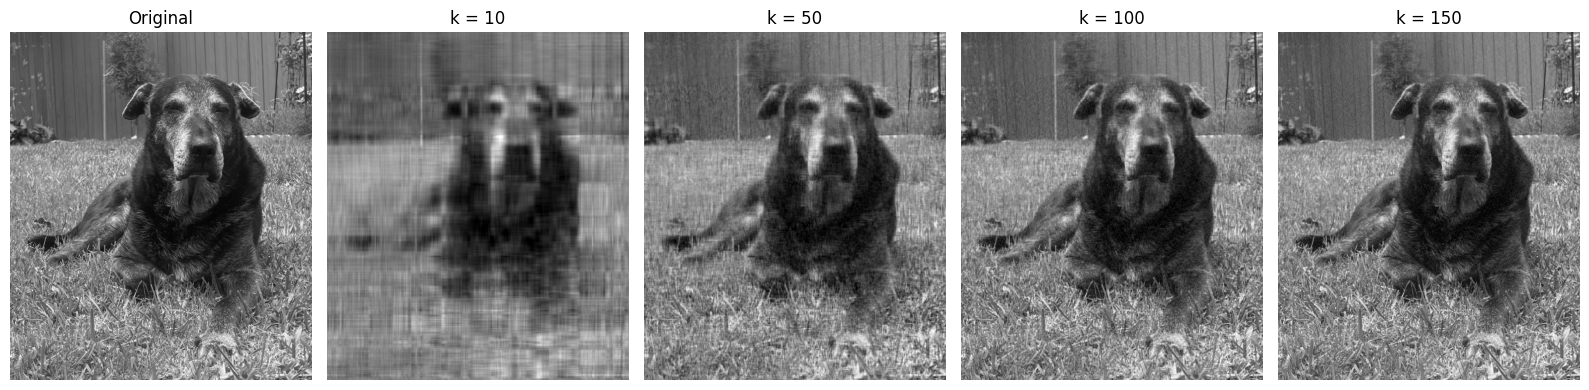

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load and convert the image to grayscale
img = Image.open("dog.jpg").convert("L")
img_array = np.array(img)

# Function to apply SVD and reconstruct the image with top k components
def compress_image_svd(img_array, k):
    U, S, VT = np.linalg.svd(img_array, full_matrices=False)
    S_k = np.diag(S[:k])
    U_k = U[:, :k]
    VT_k = VT[:k, :]
    compressed = np.dot(U_k, np.dot(S_k, VT_k))
    return np.clip(compressed, 0, 255)

# Plot original and compressed images for various k values
k_values = [10, 50, 100, 150]
plt.figure(figsize=(16, 8))

# Original
plt.subplot(1, len(k_values) + 1, 1)
plt.imshow(img_array, cmap="gray")
plt.title("Original")
plt.axis("off")

# Compressed
for i, k in enumerate(k_values):
    compressed_img = compress_image_svd(img_array, k)
    plt.subplot(1, len(k_values) + 1, i + 2)
    plt.imshow(compressed_img, cmap="gray")
    plt.title(f"k = {k}")
    plt.axis("off")

plt.tight_layout()
plt.show()


This image shows the effects of SVD-based compression on a grayscale version of the original dog photo, using different values of k, the number of singular values retained. With $k=10$, the image becomes heavily pixelated and loses nearly all detail. As $k$ increases to 50, the main structure of the image becomes recognizable, though still blurry. At 
$k=100$, the quality improves significantly with most features visible. By $k=150$, the compressed image closely resembles the original, demonstrating that higher values of k preserve more detail but require more storage. This illustrates the trade-off between compression efficiency and image quality in SVD-based image compression.

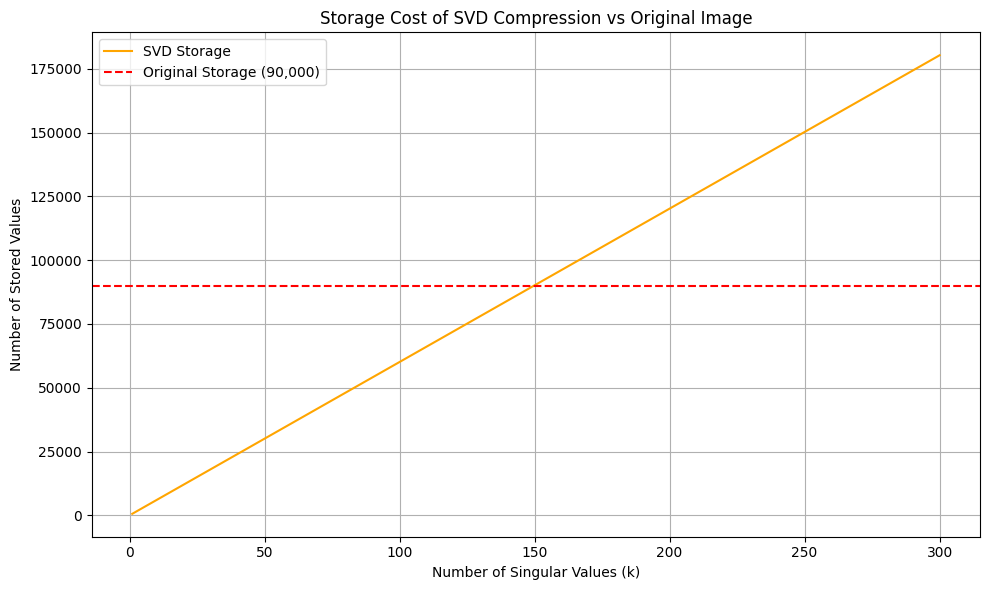

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# Image dimensions
m, n = 300, 300

# Calculate original storage size
original_storage = m * n  # 90,000

# Range of k values
k_values = np.arange(1, 301)

# Storage required for each k using SVD: U (m×k) + S (k) + V^T (k×n)
svd_storage = m * k_values + k_values + n * k_values

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(k_values, svd_storage, label="SVD Storage", color="orange")
plt.axhline(original_storage, color="red", linestyle="--", label="Original Storage (90,000)")
plt.xlabel("Number of Singular Values (k)")
plt.ylabel("Number of Stored Values")
plt.title("Storage Cost of SVD Compression vs Original Image")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


This graph compares the storage cost of SVD compression with the original image storage size for a 300×300 grayscale image. The orange line represents the number of values stored when compressing the image using different numbers of singular values $k$, calculated as $601k$. The red dashed line represents the original uncompressed storage requirement, which is 90,000 values (300×300 pixels).

We observe that at around $k=150$, the SVD storage cost intersects with the original image storage. This is the breakeven point—beyond this, using more singular values actually results in a larger total storage cost than keeping the original image. Therefore, optimal compression happens when $k$ is significantly less than 150, allowing for a reduction in size while still preserving visual quality. This tradeoff between compression level and image fidelity is at the heart of using SVD for image compression.

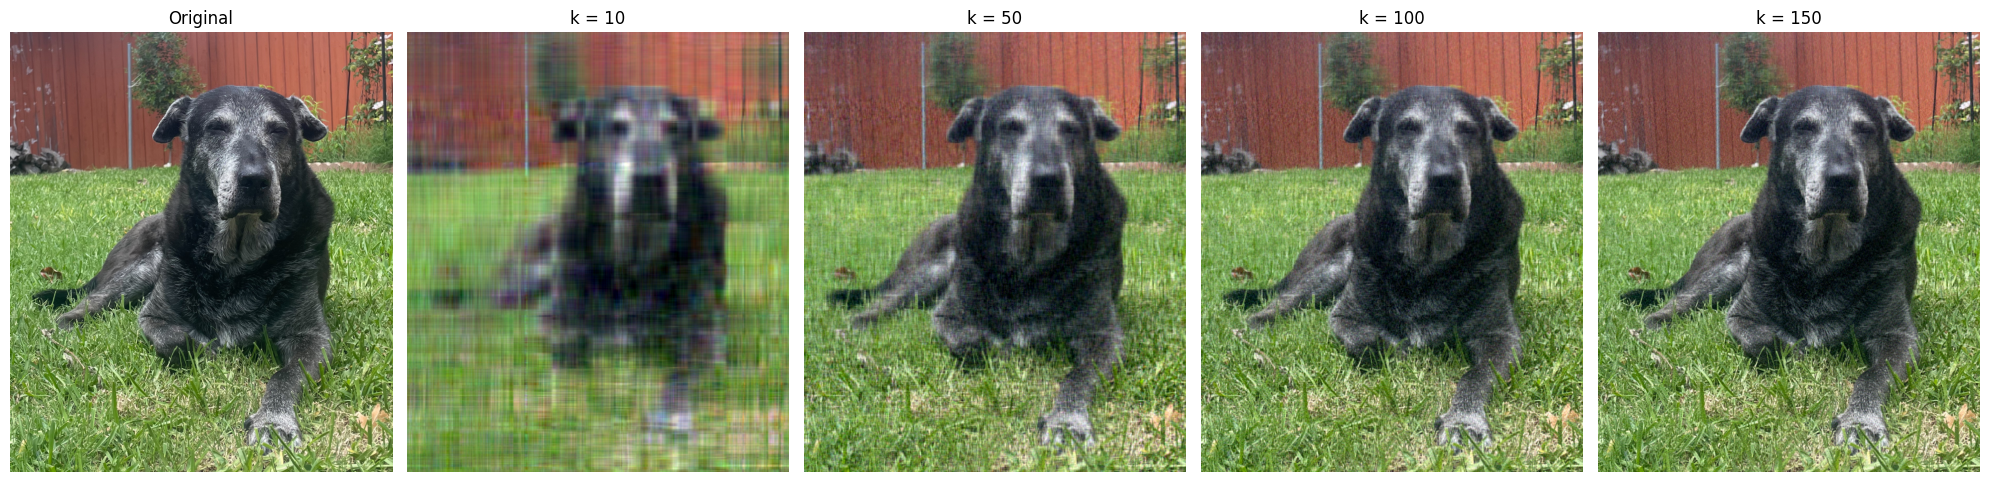

In [8]:
# Load the color image
img = Image.open("dog.jpg")
img_array = np.array(img)
height, width, _ = img_array.shape

# Function to compress a single channel using SVD
def compress_channel(channel, k):
    U, S, VT = np.linalg.svd(channel, full_matrices=False)
    S_k = np.diag(S[:k])
    U_k = U[:, :k]
    VT_k = VT[:k, :]
    return np.clip(np.dot(U_k, np.dot(S_k, VT_k)), 0, 255)

# Function to compress the full image by applying SVD to each channel
def compress_color_image(img_array, k):
    compressed = np.zeros_like(img_array)
    for i in range(3):  # RGB channels
        compressed[:, :, i] = compress_channel(img_array[:, :, i], k)
    return compressed.astype(np.uint8)

# Plot original and compressed images
k_values = [10, 50, 100, 150]
plt.figure(figsize=(20, 6))

# Original
plt.subplot(1, len(k_values) + 1, 1)
plt.imshow(img_array)
plt.title("Original")
plt.axis("off")

# Compressed
for i, k in enumerate(k_values):
    compressed_img = compress_color_image(img_array, k)
    plt.subplot(1, len(k_values) + 1, i + 2)
    plt.imshow(compressed_img)
    plt.title(f"k = {k}")
    plt.axis("off")

plt.tight_layout()
plt.show()


The color image compression results are similar to the grayscale results. At $k=10$, the image is highly compressed and blurred, and color fidelity is significantly lost. Increasing to $k=50$ improves the structure and color boundaries, but some graininess remains. With $k=100$, the image becomes much sharper, with better-preserved edges and more accurate colors. At $k=150$, the image appears nearly identical to the original, demonstrating that a substantial amount information can be retained even after discarding nearly half the singular values. 

In grayscale, the image is represented by a single matrix (intensity values), so compression is applied once. In contrast, color images consist of three channels—Red, Green, and Blue—each requiring its own SVD. As a result, color image compression is more computationally expensive and requires more storage per $k$-value compared to grayscale. However, it retains richer visual information such as hue and saturation, which are critical for photo realism. Even at lower $k$ values, color images tend to appear more visually informative than grayscale ones with the same compression level, due to the added depth from the three color channels. Thus, color compression with SVD balances computational cost with improved perceptual quality.

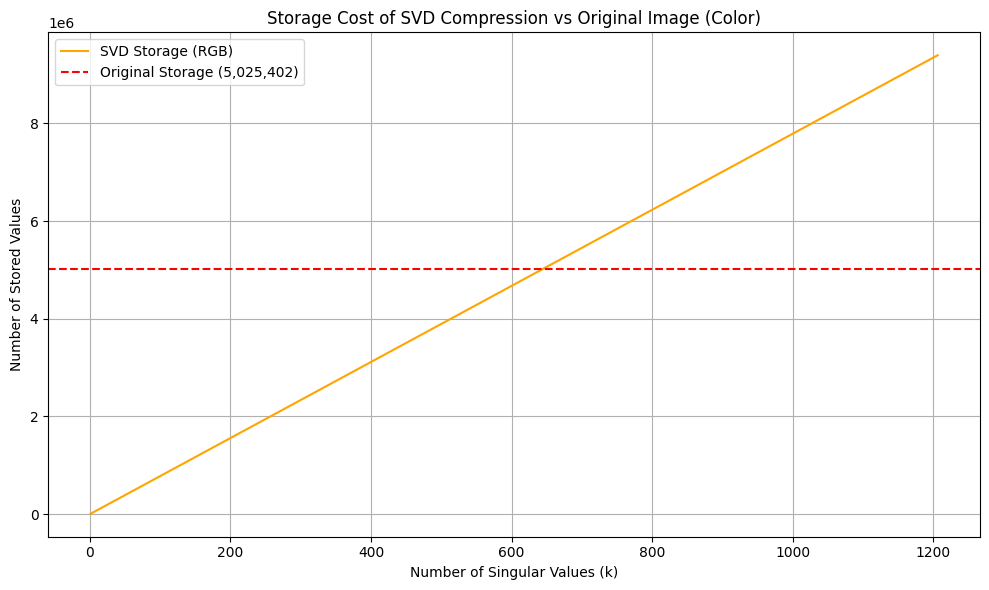

In [9]:
# Function to calculate total number of values stored per channel for given k
def storage_cost_color_image(k, height, width):
    return 3 * (k * (height + width + 1))  # 3 channels (R, G, B)

# Original size: height * width * 3 (for RGB)
original_storage = height * width * 3

# Generate storage data
k_vals = np.arange(1, min(height, width) + 1)
svd_storage = [storage_cost_color_image(k, height, width) for k in k_vals]

# Plot
plt.figure(figsize=(10, 6))
plt.plot(k_vals, svd_storage, label="SVD Storage (RGB)", color="orange")
plt.axhline(y=original_storage, color="red", linestyle="--", label=f"Original Storage ({original_storage:,})")
plt.title("Storage Cost of SVD Compression vs Original Image (Color)")
plt.xlabel("Number of Singular Values (k)")
plt.ylabel("Number of Stored Values")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

This graph shows how SVD compression storage grows with the number of singular values $k$ in a color image. Because SVD is applied separately to the red, green, and blue channels, the storage requires much more $k$ than in grayscale. We see that after about $k = 410$, compression requires more storage than the original image (marked by the red dashed line). This highlights that color images need a higher $k$ to maintain quality, but choosing too high a $k$ defeats the purpose of compression.